In [104]:
import immrax as irx

import jax
from jax import jit
import jax.numpy as jnp
from jaxtyping import Float, Array

from casadi import MX, Function, Opti, pi, tanh
import numpy as onp

In [105]:
# Vehicle model parameters
t0 = 0
tf = 3
du = 0.05  # Size of control discretization
dtdu = 10  # Number of integration time steps per control discretization
x0 = onp.array([8, 7, -onp.sqrt(3), -1])

# Platoon parameters
num_agents = 5
displacement = 0.2 * jnp.array([jnp.sqrt(3), 1, 0, 0])
x0_platoon = x0
for i in range(1, num_agents):
    x0_platoon = jnp.concatenate((x0_platoon, x0 + i * displacement))


# Disturbance parameters
w_nom = jnp.zeros(2 * num_agents)

In [106]:
class VehicleControl:
    def __init__(self, n_horizon=20, u_step=0.25, euler_steps=10):
        self.n_horizon = n_horizon
        self.u_step = u_step
        self.euler_steps = euler_steps
        self.ulim = 5
        self.constraint_padding = 1.33

        x = MX.sym("x", 4, 1)  # [px, py, vx, vy]
        u = MX.sym("u", 2, 1)  # [ax, ay]

        xdot = MX(4, 1)
        xdot[0] = x[2]
        xdot[1] = x[3]
        xdot[2] = self.ulim * tanh(u[0] / self.ulim)
        xdot[3] = self.ulim * tanh(u[1] / self.ulim)

        f = Function("f", [x, u], [xdot], ["x", "u"], ["xdot"])

        N = self.n_horizon

        def euler_integ(x, u):
            step = self.u_step / self.euler_steps
            for t in onp.arange(0, self.u_step, step):
                x = x + step * f(x, u)
            return x

        euler_res = euler_integ(x, u)
        F = Function("F", [x, u], [euler_res], ["x", "u"], ["x_next"])

        self.opti = Opti()
        self.xx = self.opti.variable(4, N + 1)
        self.uu = self.opti.variable(2, N)
        self.x0 = self.opti.parameter(4, 1)
        self.slack = self.opti.variable(1, N)

        self.opti.subject_to(self.xx[:, 0] == self.x0)
        J = 0
        for n in range(N):
            # Dynamics constraints
            self.opti.subject_to(self.xx[:, n + 1] == F(self.xx[:, n], self.uu[:, n]))

            # Penalize state and control effort
            J += (
                self.xx[0, n] ** 2
                + self.xx[1, n] ** 2
                + 0.5 * self.uu[0, n] ** 2
                + 0.5 * self.uu[1, n] ** 2
            )
            if n > 0:
                # Penalize large control changes
                J += 5e-3 * (self.uu[0, n] - self.uu[0, n - 1]) ** 2 + 5 * (
                    self.uu[1, n] - self.uu[1, n - 1]
                )
            J += 1e5 * self.slack[0, n] ** 2

            # Obstacle constraints
            self.opti.subject_to(
                (self.xx[0, n] - 4) ** 2 + (self.xx[1, n] - 4) ** 2
                >= (2.25 * self.constraint_padding) ** 2 - self.slack[0, n]
            )
            # self.opti.subject_to(
            #     (self.xx[0, n] + 4) ** 2 + (self.xx[1, n] - 4) ** 2
            #     >= 3**2 - self.slack[0, n]
            # )

        # Final state penalty
        J += (
            100 * self.xx[0, N] ** 2 + 100 * self.xx[1, N] ** 2 + 1 * self.xx[3, N] ** 2
        )
        self.opti.minimize(J)

        # Actuation constraints
        self.opti.subject_to(self.opti.bounded(-self.ulim, self.uu[0, :], self.ulim))
        self.opti.subject_to(self.opti.bounded(-self.ulim, self.uu[1, :], self.ulim))

        self.opti.solver(
            "ipopt",
            {"print_time": 0},
            {
                # "linear_solver": "mumps",
                "print_level": 0,
                "sb": "yes",
                "max_iter": 100000,
            },
        )

    def u(self, t, x):
        self.opti.set_value(self.x0, x)
        for n in range(self.n_horizon + 1):
            self.opti.set_initial(self.xx[:, n], x)
        sol = self.opti.solve()
        # print(sol.value(self.slack))
        return sol.value(self.uu[:, 0]), sol.value(self.xx[:, 1])

    def make_trajectory(self, t0, tf, x0):
        ts = onp.arange(t0, tf, self.u_step)
        us = onp.zeros((len(ts), 2))
        xs = onp.zeros((len(ts) + 1, x0.shape[0]))
        xs[0] = x0

        for i, t in enumerate(ts):
            us[i], xs[i + 1] = self.u(t, xs[i])

        return ts, xs, us

In [107]:
ts, xs, us = VehicleControl(u_step=du, euler_steps=dtdu).make_trajectory(t0, tf, x0)

In [108]:
class Platoon(irx.System):
    num_agents: int
    states_per_vehicle: int = 4  # px py vx vy
    ulim: Float[Array, "2 1"] = jnp.array([5.0, 5.0])

    kp: float = 5
    kv: float = 5

    def __init__(self, n: int) -> None:
        self.num_agents = n
        self.xlen = self.states_per_vehicle * n
        self.evolution = "continuous"

    def f(
        self,
        t: float,
        x: Float[Array, "4*num_agents"],
        u: Float[Array, "2"],
        w: Float[Array, "2*num_agents"],
    ) -> Float[Array, "4*num_agents"]:
        leader_state = x[: self.states_per_vehicle]
        input_softmax = self.ulim * jnp.tanh(u / self.ulim)
        dynamics = jnp.array(
            [
                leader_state[2],
                leader_state[3],
                input_softmax[0] + w[0],
                input_softmax[1] + w[1],
            ]
        )

        for i in range(1, self.num_agents):
            followed_state = x[
                (i - 1) * self.states_per_vehicle : i * self.states_per_vehicle
            ]
            follower_state = x[
                i * self.states_per_vehicle : (i + 1) * self.states_per_vehicle
            ]

            followed_speed = jnp.linalg.norm(followed_state[2:4])
            pd_control_x = self.kp * (
                followed_state[0]
                - follower_state[0]
                - 0.5 * followed_state[2] / followed_speed
            ) + self.kv * (followed_state[2] - follower_state[2])
            pd_control_y = self.kp * (
                followed_state[1]
                - follower_state[1]
                - 0.5 * followed_state[3] / followed_speed
            ) + self.kv * (followed_state[3] - follower_state[3])

            follower_dynamics = jnp.array(
                [
                    follower_state[2],
                    follower_state[3],
                    pd_control_x + w[2 * i],
                    pd_control_y + w[2 * i + 1],
                ]
            )
            dynamics = jnp.concatenate([dynamics, follower_dynamics])

        return dynamics

In [109]:
us = jnp.array(us)


def mpc_inputs(t: jax.Array, x: Float[Array, "4*num_agents"]) -> Float[Array, "2"]:
    # jax.debug.print("t: {0} ({1})", (t / du).astype(int), t / du)
    return us[(t / du).astype(int)]


def disturbance(
    t: float, x: Float[Array, "4*num_agents"]
) -> Float[Array, "2*num_agents"]:
    return w_nom


ind = Platoon(num_agents)
traj = ind.compute_trajectory(
    t0, tf, x0_platoon, (mpc_inputs, disturbance), solver="euler", dt=du / dtdu
)

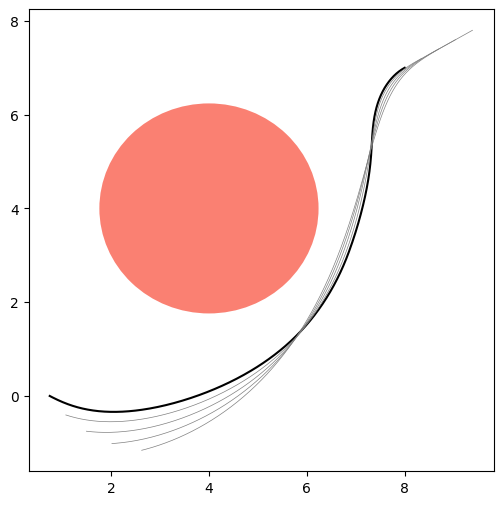

In [110]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure(figsize=(6, 6))
ax = plt.gca()

circle = patches.Circle((4, 4), 2.25 - 1e-2, facecolor="salmon", label="Obstacle")
ax.add_patch(circle)  # Obstacle

# ax.plot(xs[:, 0], xs[:, 1], color="black", label="Nominal Trajectory")  # MPC trajectory
ax.plot(
    traj.ys[:, 0], traj.ys[:, 1], color="black", label="Nominal Trajectory"
)  # immrax nominal trajectory
for i in range(1, num_agents):
    ax.plot(traj.ys[:, 4 * i], traj.ys[:, 4 * i + 1], color="gray", linewidth=0.5)